## Going to load the data
I loaded the data and modified the paths to the images to make sure that the program works when it runs on an EC2 instance with a GPU on AWS.

In [1]:
import csv

data_folder = "./data"

data = []
steering = []

# steering offset hyperparameter
offset = 0.2

temp = True

def modify_path(path):
    source = path.split("\\")[-1]
    source = data_folder + "/IMG/" + source
    return source

with open(data_folder + "/driving_log.csv", "r") as file:
    reader = csv.reader(file)
    for line in reader:
        center = float(line[3])
        left = center + offset
        right = center - offset
        
        data.append([modify_path(line[0]), center])
        data.append([modify_path(line[1]), left])
        data.append([modify_path(line[2]), right])
        
        steering.append(center)
        steering.append(left)
        steering.append(right)
        
        if(temp):
            print(modify_path(line[0]))
            print(modify_path(line[1]))
            print(modify_path(line[2]))
            temp = False
        
# print(line)
print("There are", len(data), "samples.")
print("The data is in the following format:")
print("\tCenter Image | Left Image | Right Image | Steering | Throttle | Brake | Speed")

./data/IMG/center_2017_03_04_20_17_00_855.jpg
./data/IMG/left_2017_03_04_20_17_00_855.jpg
./data/IMG/right_2017_03_04_20_17_00_855.jpg
There are 23334 samples.
The data is in the following format:
	Center Image | Left Image | Right Image | Steering | Throttle | Brake | Speed


#### Visualize the data

In [2]:
from matplotlib import pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def display_images(normal, cropped, flipped, lm, cm, rm):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)

    # Fine-tune figure; make subplots spaced out
    f.subplots_adjust(wspace = .3)
    f.set_size_inches(12, 5)

    ax1.imshow(normal)
    ax1.set_title("Normal: " + str(lm) + " degrees")
    ax2.imshow(cropped)
    ax2.set_title("Cropped: " + str(cm) + " degrees")
    ax3.imshow(flipped)
    ax3.set_title("Flipped: " + str(rm) + " degrees")
    plt.show()

In [3]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# going to split the dataset into train and validation sets right now
train, test = train_test_split(data, test_size=0.2)

print("There are", len(train), " samples in the training set.")
print("There are", len(test), " samples in the test set.")

print(train[0][0])
print(train[0][1])

There are 18667  samples in the training set.
There are 4667  samples in the test set.
./data/IMG/right_2017_03_04_20_24_10_603.jpg
0.06082290000000001


# Data preprocessing:
1. Crop all images so that only the road visible and not the sky.
2. Increase sample size by flipping all images in the the training set. There are less than 60k images and less than 20k steering measurements in this training set. It would be prudent to create some more using diferent transformations.
3. Shuffle the data

In [4]:
# cropping the images
def crop_image(image):
    return image[55:140, 0:320]

def flip_image(image, measurement):
    return cv2.flip(image, 1), -1 * measurement

# Data Visualization

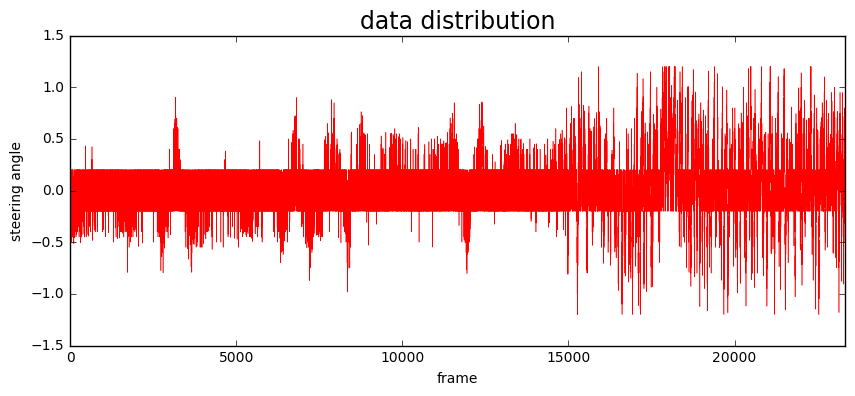

In [5]:
plt.figure(figsize=(10,4))
x = [range(len(steering))]
x = np.squeeze(np.asarray(x))
y = np.asarray(steering)
plt.xlim(0,len(steering)-1)
plt.title('data distribution', fontsize=17)
plt.xlabel('frame')
plt.ylabel('steering angle')
plt.plot(x,y, 'r', linewidth=0.4)
plt.show()

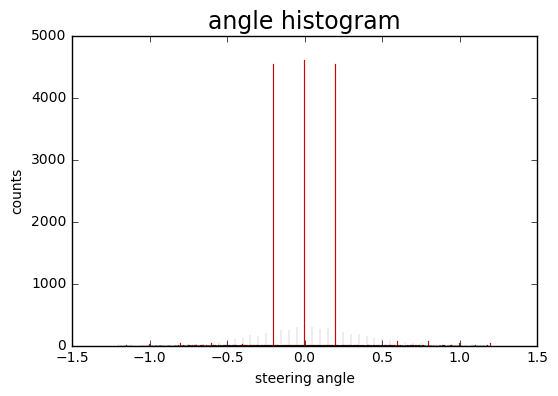

In [6]:
plt.hist(steering, bins= len(np.unique(steering)), color= 'red', linewidth=0.1)
plt.title('angle histogram', fontsize=17)
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.show()

In [7]:
#getting rid of unnecesary data
steering = []
data = []

# Efficiently load images as needed into memory
This is make better use of available resources. Up until this point, I was loading all images into memory and running into memory issues. By using a generator, I will be making better use of available resources.

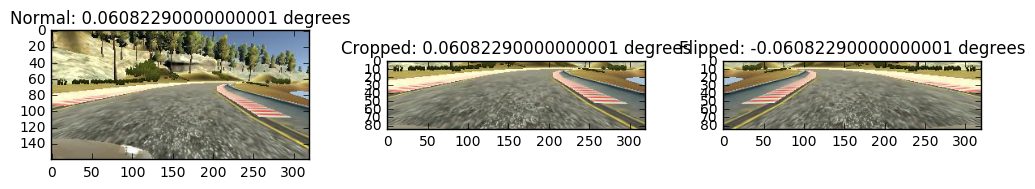

Images will have a shape: (85, 320, 3)
<class 'generator'>


In [8]:
from sklearn.utils import shuffle

image = cv2.imread(train[0][0])
# the image is originally opened in BGR, gonna have to change it to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
measurement = train[0][1]
cropped = crop_image(image)
flipped, flipped_measure = flip_image(cropped, measurement)
display_images(image, cropped, flipped, measurement, measurement, flipped_measure)

# going to define a value for use in the model
image_shape = cropped.shape
print("Images will have a shape:", image_shape)

# have to define an infinite stream that returns batches of images  
def stream_training(samples, batch_size=256):
    num_samples = len(samples)
    shuffle(samples)
    while True:
        for current_offset in range(0, num_samples, batch_size):
            # will be converted to numpy arrays because keras expects numpy arrays
            images = []
            measurements = []
            current_batch = samples[current_offset : current_offset + batch_size]
            
            for current in current_batch:
                image = cv2.imread(current[0])
                # the image is originally opened in BGR, gonna have to change it to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                measurement = current[1]

                # pre-processing the images here
                cropped = crop_image(image)
                flipped, flipped_measure = flip_image(cropped, measurement)
                
                images.append(cropped)
                measurements.append(measurement)
                images.append(flipped)
                measurements.append(flipped_measure)
            yield np.array(images), np.array(measurements)
            
training_stream = stream_training(train)
print(type(training_stream))

In [9]:
# have to define an infinite stream that returns batches of images  
def stream_test(samples, batch_size=256):
    num_samples = len(samples)
    shuffle(samples)
    while True:
        for current_offset in range(0, num_samples, batch_size):
            # will be converted to numpy arrays because keras expects numpy arrays
            images = []
            measurements = []
            current_batch = samples[current_offset : current_offset + batch_size]
            
            for current in current_batch:
                image = cv2.imread(current[0])
                # the image is originally opened in BGR, gonna have to change it to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                measurement = current[1]
                images.append(cropped)
                measurements.append(measurement)
            yield np.array(images), np.array(measurements)

testing_stream = stream_test(test)
print(type(testing_stream))

<class 'generator'>


I now have 2X as many images and 6X as many measurements in my training set than I had before. However, it would be better if I applied a few transformations to the images to prevent overfitting and promote better generalization.

### Random shift (in case, I need more data)
According to Nvidia's paper "End to End Learning for Self-Driving Cars", we should consider the center of each lane to the "ground truth". Unfortunately, human drivers do not always drive in the center of the lane. 
So, we have to manually calibrate the lane center associated with each frame. We do this by transforming the original images to account for departures from the "ground truth". The steering label for transformed images is adjusted to one that would steer the vehicle back to the desired location and orientation in two seconds.

In [10]:
# Shuffle the data
# from sklearn.utils import shuffle
# images, measurements = shuffle(images, measurements)

# Developing the model
I'm modelling my pipeline after GoogLenet. This means that I will make use of inception modules in my pipeline.

In [11]:
from keras.layers import Merge, merge
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential

# the following arrays define the number of filters for each part of an inception layer 
# for each of the inception layers
inception_layer1 = [64, 96, 128, 16, 32, 32]
inception_layer2 = [128, 128, 192, 32, 96, 64]
inception_layer3 = [192, 96, 208, 16, 48, 64]
inception_layer4 = [160, 112, 224, 24, 64, 64]
inception_layer5 = [128, 128, 256, 24, 64, 64]
inception_layer6 = [112, 144, 288, 32, 64, 64]
inception_layer7 = [256, 160, 320, 32, 128, 128]
inception_layer8 = [256, 160, 320, 32, 128, 128]
inception_layer9 = [384, 192, 384, 48, 128, 128]

# method to build the inception layers
# 3x3 reduce and 5x5 reduce stand for the number of 1x1 filters in the reduce layer used
# before the 3x3 and 5x5 filters
# this method adds 2 to the overall height of the model
def inception(input_value, num_filters):
    
    # 1x1 
    part1 = Convolution2D(num_filters[0], 1, 1, border_mode='same', activation='relu')(input_value)
    # 3x3 reduce
    part2 = Convolution2D(num_filters[1], 1, 1, border_mode='same', activation='relu')(input_value)
    # 3x3
    part2 = Convolution2D(num_filters[2], 3, 3, border_mode='same', activation='relu')(part2)
    # 5x5 reduce
    part3 = Convolution2D(num_filters[3], 1, 1, border_mode='same', activation='relu')(input_value)
    # 5x5
    part3 = Convolution2D(num_filters[4], 5, 5, border_mode='same', activation='relu')(part3)
    # maxpool
    part4 = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same')(input_value)
    # pool projection
    part4 = Convolution2D(num_filters[5], 1, 1, border_mode='same', activation='relu')(part4)

    return merge([part1, part2, part3, part4], mode='concat', concat_axis=3)

def inceptionSeq(input_value, num_filters):
    
    shape = (input_value)
    
    input_value = Input(shape = input_value)
    
    part1 = Sequential()
    # 1x1 
    part1.add(Convolution2D(num_filters[0], 1, 1, border_mode='same', activation='relu', 
                            input_shape = shape))
    
    part2 = Sequential()
    # 3x3 reduce
    part2.add(Convolution2D(num_filters[1], 1, 1, border_mode='same', activation='relu', 
                            input_shape = shape))
    # 3x3
    part2.add(Convolution2D(num_filters[2], 3, 3, border_mode='same', activation='relu'))
    
    part3 = Sequential()
    # 5x5 reduce
    part3.add(Convolution2D(num_filters[3], 1, 1, border_mode='same', activation='relu', 
                            input_shape = shape))
    # 5x5
    part3.add(Convolution2D(num_filters[4], 5, 5, border_mode='same', activation='relu'))
    
    part4 = Sequential()
    # maxpool
    part4.add(MaxPooling2D((3, 3), strides=(1, 1), border_mode='same', 
                            input_shape = shape))
    # pool projection
    part4.add(Convolution2D(num_filters[5], 1, 1, border_mode='same', activation='relu'))
    
    return Merge([part1, part2, part3, part4], mode='concat')

Using TensorFlow backend.


In [12]:
from keras.layers import Dropout, Flatten, Input
from keras.layers.pooling import AveragePooling2D
from keras.layers.core import Dense, Flatten, Dropout, Activation
from keras.models import Model

# method to build the pipeline
def build_GoogLenet():
    input_img = Input(shape=image_shape)
    
    # convolution: (7x7, stride = 2, 64 filters)
    layer1 = Convolution2D(64,7,7,subsample=(2,2),border_mode='same',activation='relu')(input_img)
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid)
    layer1 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same')(layer1)
    
    # 3x3 reduce convolution: (1x1, stride = 1, 64 filters)
    layer2 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(layer1)
    # convolution: (3x3, stride = 1, 192 filters)
    layer2 = Convolution2D(192, 3, 3, border_mode='same', activation='relu')(layer2)
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid)
    layer2 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same')(layer2)
    
    # inception module 1
    layer3 = inception(layer2, inception_layer1)
    
    # inception module 2
    layer4 = inception(layer3, inception_layer2)
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid)
    layer4 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same')(layer4)
    
    #inception module 3
    layer5 = inception(layer4, inception_layer3)
    
    #inception module 3
    layer6 = inception(layer5, inception_layer4)
    
    #inception module 3
    layer7 = inception(layer6, inception_layer5)
    
    #inception module 3
    layer8 = inception(layer7, inception_layer6)
    
    #inception module 3
    layer9 = inception(layer8, inception_layer7)
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid)
    layer10 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same')(layer9)
    
    #inception module 3
    layer11 = inception(layer10, inception_layer8)
    
    #inception module 3
    layer12 = inception(layer11, inception_layer9)
    
    # average pooling: (7x7, stride = 1)
    layer13 = AveragePooling2D(pool_size=(3, 3),strides=(1,1))(layer12)
    
    # dropout: 40%
    layer14 = Dropout(0.4)(layer13)
    
    # Flatten
    layer15 = Flatten()(layer14)
    
    # Dense layer
    layer16 = Dense(1)(layer15)
    
    layer17 = Activation('softmax')(layer16)
    
    model = Model(input=input_img, output = layer17)

    return model

In [13]:
import math

def build_GoogLenetSeq():
    # input = (85, 320, 3)
    model = Sequential()
    
    # convolution: (7x7, stride = 2, 64 filters) output = (42, 160, 64)
    model.add(Convolution2D(64,7,7,subsample=(2,2),border_mode='same',activation='relu', 
                            input_shape = image_shape))
    # curr_shape = (43, 160, 64)
    curr_shape = (math.ceil(image_shape[0]/2), math.ceil(image_shape[1]/2), 64)
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid) output = (21, 80, 64)
    model.add(MaxPooling2D((3, 3), strides=(2, 2), border_mode='same'))
    
    # curr_shape = (22, 80, 64)
    curr_shape = (math.ceil(curr_shape[0]/2), math.ceil(curr_shape[1]/2), 64)
    
    # 3x3 reduce convolution: (1x1, stride = 1, 64 filters) output = (21, 80, 64)
    model.add(Convolution2D(64, 1, 1, border_mode='same', activation='relu'))
    # convolution: (3x3, stride = 1, 192 filters) output = (21, 80, 192)
    model.add(Convolution2D(192, 3, 3, border_mode='same', activation='relu'))
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid) output = (11, 40, 192)
    maxpool1 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same')
    model.add(maxpool1)
        
    # curr_shape = (10, 40, 192)
    curr_shape = (math.ceil(curr_shape[0]/2), math.ceil(curr_shape[1]/2), 192)
    
    # inception module 1: output = (11, 40, 256)
    print("inception module 1")
    inception1 = inceptionSeq(curr_shape, inception_layer1)
    print(type(inception1))
    model.add(inception1)
        
    # curr_shape = (11, 40, 192)
    curr_shape = (curr_shape[0], curr_shape[1], 192)
    
    # inception module 2: output = (10, 40, 480)
    print("inception module 2")
    inception2 = inceptionSeq(curr_shape, inception_layer2)
    model.add(inception2)
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid) output = (5, 20, 256)
    maxpool2 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same')(inception2)
    model.add(maxpool2)
    
    # curr_shape = (5, 20, 256)
    curr_shape = (math.ceil(curr_shape[0]/2), math.ceil(curr_shape[1]/2), 256)
    
    #inception module 3: output = (5, 20, 512)
    print("inception module 3")
    inception3 = inceptionSeq(curr_shape, inception_layer3)
    model.add(inception3)
    
    #inception module 4: output = (5, 20, 512)
    print("inception module 4")
    inception4 = inceptionSeq(inception3, inception_layer4)
    model.add(inception4)
    
    #inception module 5: output = (5, 20, 512)
    print("inception module 5")
    inception5 = inceptionSeq(inception4, inception_layer5)
    model.add(inception5)
    
    #inception module 6: output = (5, 20, 528)
    print("inception module 6")
    inception6 = inceptionSeq(inception5, inception_layer6)
    model.add(inception6)
    
    #inception module 7: output = (5, 20, 832)
    print("inception module 7")
    model.add(inceptionSeq(inception6, inception_layer7))
    
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid): output = (2, 10, 832)
    maxpool3 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same')
    model.add(maxpool3)
    
    # curr_shape = (2, 10, 832)
    curr_shape = (math.ceil(curr_shape[0]/2), math.ceil(curr_shape[1]/2), 832)
    
    #inception module 8: output = (2, 10, 832)
    print("inception module 8")
    inception8 = inceptionSeq(curr_shape, inception_layer8)
    model.add(inception8)
    
    #inception module 9: output = (5, 20, 1024)
    print("inception module 9")
    model.add(inceptionSeq(inception8, inception_layer9))
    
    # average pooling: (5x5, stride = 1): output = (1, 4, 1024)
    model.add(AveragePooling2D(pool_size=(3,3),strides=(1,1)))
    
    # dropout: 40%: output = (1, 4, 1024)
    model.add(Dropout(0.4))
    
    # Flatten: output = (1, 1, 4100)
    model.add(Flatten())
    
    # Dense layer: output = (1, 1, 1)
    model.add(Dense(1))
    
    # Softmax: output = (1, 1, 1)
    model.add(Activation('softmax'))
              
    return model

# Compilation and Training 

Model will use the streams I created earlier to train and test.

In [16]:
import os.path

model = build_GoogLenet()
if os.path.isfile("model.h5"):
    model.load_weights("model.h5", by_name=True)

In [17]:
model.compile('adam', 'mean_squared_error', ['accuracy'])

In [18]:
model.fit_generator(training_stream, samples_per_epoch = len(train), 
                    validation_data = testing_stream, 
                    nb_val_samples=len(test), 
                    nb_epoch=10)

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
from keras.models import load_model

model.save_weights('model.h5')  # creates a HDF5 file 'model.h5' and saves the weights